In [ ]:

!pip uninstall -y pyarrow fsspec requests
!pip install pyarrow==14.0.1 fsspec==2024.6.1 requests==2.31.0
!pip install datasets transformers scikit-learn torch pandas==1.3.3


  Using cached datasets-2.20.0-py3-none-any.whl.metadata (19 kB)
  Using cached pyarrow-17.0.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached xxhash-3.4.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py310-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2024.5.0-py3-none-any.whl.metadata (11 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using 

In [ ]:
try:
    import pandas as pd
    from datasets import load_dataset, Dataset
    from transformers import DistilBertTokenizerFast, DistilBertForQuestionAnswering, TrainingArguments, Trainer
    import torch
    import numpy as np
except ImportError as e:
    print("A required package is missing:", e)
    print("Please install the missing package using pip:")
    print("pip install datasets transformers scikit-learn torch pandas")


In [ ]:
!pip install datasets

from datasets import load_dataset

# Load the dataset
dataset = load_dataset("toughdata/quora-question-answer-dataset")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/56402 [00:00<?, ? examples/s]

In [ ]:
# Explore the dataset
print(dataset['train'].features)
print(dataset['train'].column_names)
print(dataset['train'][0])

{'question': Value(dtype='string', id=None), 'answer': Value(dtype='string', id=None)}
['question', 'answer']
{'question': 'Why whenever I get in the shower my girlfriend want to join?', 'answer': 'Isn’t it awful? You would swear that there wasn’t enough hot water to go around!\n'}


In [ ]:
import pandas as pd

# Convert dataset to DataFrame
df = pd.DataFrame(dataset['train'])

# Remove duplicate questions
df = df.drop_duplicates(subset=['question'])
df

,question,answer
0,Why whenever I get in the shower my girlfriend...,Isn’t it awful? You would swear that there was...
1,"What is a proxy, and how can I use one?",A proxy server is a system or router that prov...
2,"What song has the lyrics ""someone left the cak...",MacArthur's Park\n
3,I am the owner of an adult website called http...,Don't let apps that are liers put adds on your...
4,Does the Bible mention anything about a place ...,St. John in the book of Revelation mentions an...
...,...,...
55873,Is the Apple Thunderbolt display 4k?,Yes Thunderbolt 1 & 2 support 4K as they are t...
56050,Can I get a German long-term visa after gettin...,Basically yes. This depends on whether the iss...
56119,What sources have previously revealed informat...,Karen Taylor is reportedly leaving EastEnders ...
56136,Is the Piperinox weight loss supplement effect...,"Yes, Piperinox is effective and worth buying. ..."


In [ ]:
# Check for missing values
print(df.isnull().sum())

# Drop rows with missing values
df = df.dropna()


question    0
answer      0
dtype: int64


In [ ]:
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with single space
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

# Apply text preprocessing
df['question'] = df['question'].apply(preprocess_text)
df['answer'] = df['answer'].apply(preprocess_text)


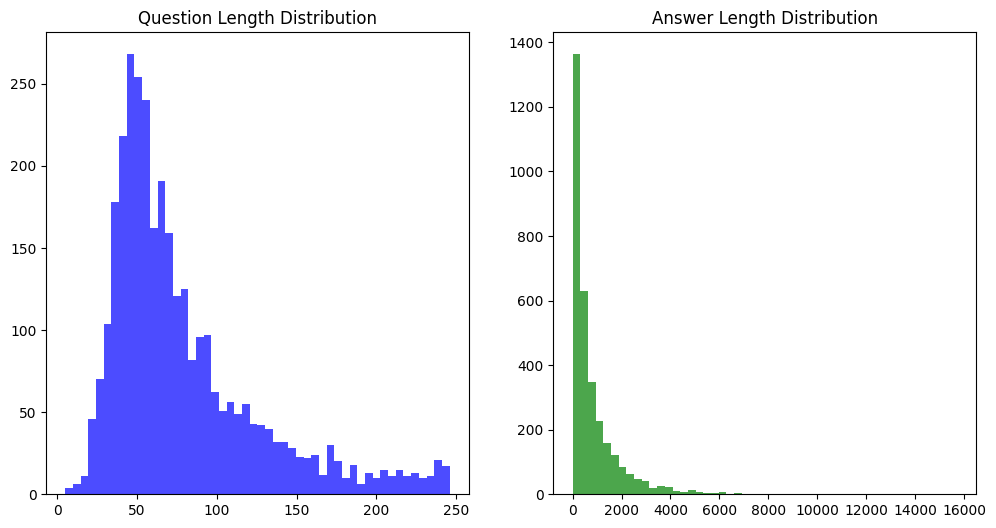

In [ ]:
import matplotlib.pyplot as plt

# Length distribution of questions and answers
df['question_length'] = df['question'].apply(len)
df['answer_length'] = df['answer'].apply(len)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df['question_length'], bins=50, color='blue', alpha=0.7)
plt.title('Question Length Distribution')

plt.subplot(1, 2, 2)
plt.hist(df['answer_length'], bins=50, color='green', alpha=0.7)
plt.title('Answer Length Distribution')

plt.show()


In [ ]:
# Adjust column name if necessary
df = df.drop_duplicates(subset=['question'])


In [ ]:
# Example if there are no categories
print("Class balance check is not applicable for this dataset.")


Class balance check is not applicable for this dataset.


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['question'], padding='max_length', truncation=True)

# Apply tokenization
tokenized_datasets = dataset.map(tokenize_function, batched=True)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/56402 [00:00<?, ? examples/s]

In [ ]:
print(df.columns)
# Remove duplicate questions
df = df.drop_duplicates(subset=['question'])


Index(['question', 'answer', 'question_length', 'answer_length'], dtype='object')


In [ ]:
from datasets import Dataset

# Convert DataFrame to dataset
cleaned_dataset = Dataset.from_pandas(df)

# Save dataset to disk
cleaned_dataset.save_to_disk('cleaned_train_dataset')


Saving the dataset (0/1 shards):   0%|          | 0/3234 [00:00<?, ? examples/s]

In [ ]:
from datasets import load_from_disk

# Load the dataset
train_dataset = load_from_disk('cleaned_train_dataset')


In [ ]:
print(train_dataset[0])  # Check a sample from the dataset


{'question': 'why whenever i get in the shower my girlfriend want to join', 'answer': 'isnt it awful you would swear that there wasnt enough hot water to go around ', 'question_length': 59, 'answer_length': 77, '__index_level_0__': 0}


In [ ]:
from sklearn.model_selection import train_test_split

# Split data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Convert DataFrames to datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
train_dataset.save_to_disk('train_dataset')
val_dataset.save_to_disk('val_dataset')
test_dataset.save_to_disk('test_dataset')

Saving the dataset (0/1 shards):   0%|          | 0/2587 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/323 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/324 [00:00<?, ? examples/s]

In [ ]:
from datasets import load_from_disk

# Load the preprocessed datasets
train_dataset = load_from_disk('train_dataset')
val_dataset = load_from_disk('val_dataset')
test_dataset = load_from_disk('test_dataset')


In [ ]:
from transformers import BertTokenizer, BertForQuestionAnswering, TrainingArguments, Trainer

# Load tokenizer and model
from transformers import BertTokenizerFast

# Load the fast tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Print column names to verify
print(train_dataset.column_names)


['question', 'answer', 'question_length', 'answer_length', '__index_level_0__']


In [ ]:
from transformers import BertTokenizerFast

# Load the fast tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    answers = [a.strip() for a in examples["answer"]]
    inputs = tokenizer(
        questions,
        answers,
        max_length=512,
        truncation=True,
        padding='max_length',
        return_offsets_mapping=True
    )

    start_positions = []
    end_positions = []

    for i, offset in enumerate(inputs['offset_mapping']):
        answer = answers[i]
        question = questions[i]
        start_char = question.find(answer)
        end_char = start_char + len(answer)

        sequence_ids = inputs.sequence_ids(i)

        if sequence_ids is None:  # Check if sequence_ids is not available
            start_positions.append(0)
            end_positions.append(0)
            continue

        # Find the start and end of the context in the tokenized input
        idx = 0
        while idx < len(sequence_ids) and sequence_ids[idx] != 1:
            idx += 1
        context_start = idx

        if context_start == len(sequence_ids):  # If no context start found
            start_positions.append(0)
            end_positions.append(0)
            continue

        while idx < len(sequence_ids) and sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        if end_char < inputs['offset_mapping'][i][context_start][0] or start_char > inputs['offset_mapping'][i][context_end][1]:
            start_positions.append(0)
            end_positions.append(0)
        else:
            start_token_idx = context_start
            while start_token_idx <= context_end and inputs['offset_mapping'][i][start_token_idx][0] <= start_char:
                start_token_idx += 1
            end_token_idx = context_end
            while end_token_idx >= context_start and inputs['offset_mapping'][i][end_token_idx][1] >= end_char:
                end_token_idx -= 1

            start_positions.append(start_token_idx - 1)
            end_positions.append(end_token_idx + 1)

    inputs.update({
        'start_positions': start_positions,
        'end_positions': end_positions,
    })

    return inputs


# Apply preprocessing
train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/2587 [00:00<?, ? examples/s]

Map:   0%|          | 0/323 [00:00<?, ? examples/s]

Map:   0%|          | 0/324 [00:00<?, ? examples/s]

In [ ]:
# Set format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'start_positions', 'end_positions'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'start_positions', 'end_positions'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])


In [ ]:
# Print a sample from the dataset to verify
print(train_dataset[0])


{'input_ids': tensor([  101,  2349,  2000,  1037, 21934,  4003,  5881,  3277,  1037,  7192,
         2386,  9685,  2039,  2026,  3042,  2005,  3098,  1996,  2067,  3104,
         1997,  2026, 19102,  9088,  1055,  2581,  3341,  1998,  3718,  1996,
        21934,  4003,  2021,  2044,  2008,  2026,  3042,  2003,  2205,  2474,
        22772,  2054,  2323,  1045,  2079,   102,  2017,  2323,  2175,  2000,
         7192,  3124,  1998,  4863,  8030, 10808,  2006,  2049,  2219,  2097,
         2025,  3426,  2474, 12588,  3568,  5987,  2000,  3477,  2769,  2005,
         1996,  7192,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 

In [ ]:
# Load model
model = DistilBertForQuestionAnswering.from_pretrained('distilbert-base-uncased')

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',  # Directory to save model checkpoints and results
    evaluation_strategy="epoch",  # Evaluate model at the end of each epoch
    learning_rate=2e-5,  # Learning rate for optimizer
    per_device_train_batch_size=16,  # Increase batch size for training
    per_device_eval_batch_size=16,  # Increase batch size for evaluation
    num_train_epochs=2,  # Reduce the number of epochs to train
    weight_decay=0.01,  # Weight decay for regularization
    logging_dir='./logs',  # Directory to save logs
    logging_steps=1000,  # Log less frequently to reduce overhead
)



/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,  # Your model instance
    args=training_args,  # Training arguments
    train_dataset=train_dataset,  # Training dataset
    eval_dataset=val_dataset,  # Validation dataset
    tokenizer=tokenizer,  # Tokenizer instance for encoding
)



In [ ]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.466190


Epoch,Training Loss,Validation Loss
1,No log,0.466190
2,No log,0.449356


TrainOutput(global_step=324, training_loss=0.7485400541329089, metrics={'train_runtime': 18812.7921, 'train_samples_per_second': 0.275, 'train_steps_per_second': 0.017, 'total_flos': 675999139565568.0, 'train_loss': 0.7485400541329089, 'epoch': 2.0})

In [ ]:
# Evaluate the model
eval_results = trainer.evaluate(eval_dataset=val_dataset)
print(eval_results)

# Evaluate on test set
test_results = trainer.evaluate(eval_dataset=test_dataset)
print("Test results:", test_results)

{'eval_loss': 0.4493560791015625, 'eval_runtime': 314.1713, 'eval_samples_per_second': 1.028, 'eval_steps_per_second': 0.067, 'epoch': 2.0}
Test results: {'eval_runtime': 315.0265, 'eval_samples_per_second': 1.028, 'eval_steps_per_second': 0.067, 'epoch': 2.0}


In [ ]:
#Predict the model
predictions = trainer.predict(test_dataset=test_dataset)
print(predictions)


PredictionOutput(predictions=(array([[-4.0912585, -4.842749 , -4.7315884, ..., -4.849039 , -4.85169  ,
        -4.828596 ],
       [-3.6348276, -4.950371 , -4.808111 , ..., -4.9984064, -4.986994 ,
        -4.9793816],
       [-3.5174737, -4.940222 , -4.8232217, ..., -4.9373856, -4.9736376,
        -4.963232 ],
       ...,
       [-2.3417788, -4.805009 , -4.710664 , ..., -4.9670277, -4.9093122,
        -4.8677244],
       [-2.500022 , -4.7378817, -4.8150606, ..., -4.800597 , -4.872816 ,
        -4.8847246],
       [-4.3803205, -4.7377033, -4.6776776, ..., -4.6249504, -4.957778 ,
         7.00204  ]], dtype=float32), array([[-6.5276575, -7.17715  , -7.2782073, ..., -7.339403 , -7.3624325,
        -7.4161577],
       [-5.447672 , -7.011846 , -7.0843916, ..., -7.242277 , -7.2349763,
        -7.273232 ],
       [-5.2910213, -7.0125585, -7.0662313, ..., -7.187635 , -7.267488 ,
        -7.286909 ],
       ...,
       [-3.6146705, -6.9907026, -7.0588694, ..., -7.214432 , -7.2039275,
        -7

In [ ]:
# Save the model
model.save_pretrained('./saved_distilbert_model')

# Save the tokenizer
tokenizer.save_pretrained('./saved_distilbert_model')


('./saved_distilbert_model/tokenizer_config.json',
 './saved_distilbert_model/special_tokens_map.json',
 './saved_distilbert_model/vocab.txt',
 './saved_distilbert_model/added_tokens.json')

In [ ]:
from transformers import DistilBertForQuestionAnswering, DistilBertTokenizer

# Load the model and tokenizer
model = DistilBertForQuestionAnswering.from_pretrained('./saved_distilbert_model')
tokenizer = DistilBertTokenizer.from_pretrained('./saved_distilbert_model')

# Example inference function with improved handling for invalid indices and special tokens
def answer_question(question, context):
    inputs = tokenizer.encode_plus(question, context, return_tensors='pt', truncation=True, padding=True)
    input_ids = inputs["input_ids"].tolist()[0]

    outputs = model(**inputs)
    start_scores, end_scores = outputs.start_logits, outputs.end_logits

    # Debugging: Print scores and tokens
    print("Tokenized input ids:", tokenizer.convert_ids_to_tokens(input_ids))
    print("Start scores:", start_scores)
    print("End scores:", end_scores)

    start_index = start_scores.argmax().item()
    end_index = end_scores.argmax().item()

    # Debugging: Print indices
    print("Start index:", start_index)
    print("End index:", end_index)

    # Handle invalid indices by finding the best span
    if start_index > end_index:
        # Find the span with the highest joint probability of start and end
        max_prob = float('-inf')
        best_start, best_end = 0, 0
        for i in range(len(input_ids)):
            for j in range(i, len(input_ids)):
                prob = start_scores[0, i].item() + end_scores[0, j].item()
                if prob > max_prob:
                    best_start, best_end = i, j
                    max_prob = prob
        start_index, end_index = best_start, best_end
        print(f"Adjusted indices: start_index ({start_index}), end_index ({end_index})")

    # Ensure valid indices again
    if start_index <= end_index:
        # Avoid special tokens
        if input_ids[start_index] in tokenizer.all_special_ids:
            start_index += 1
        if input_ids[end_index] in tokenizer.all_special_ids:
            end_index -= 1
        if start_index <= end_index:
            answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[start_index:end_index+1]))
        else:
            answer = "Unable to find a valid answer span."
    else:
        answer = "Unable to find a valid answer span."

    return answer

# Example 1 usage
#context = "Transformers are very useful in natural language processing tasks."
#question = "What are transformers useful for?"

# Example 2 Test with another context and question
#context = "OpenAI is an AI research and deployment company. Our mission is to ensure that artificial general intelligence (AGI) benefits all of humanity."
#question = "What is the mission of OpenAI?"

#Example 3
context = "The Amazon rainforest is the largest rainforest in the world. It is known for its biodiversity and is home to many unique species of plants and animals."
question = "What is the Amazon rainforest known for?"



# Get the answer
print("Answer:", answer_question(question, context))


Tokenized input ids: ['[CLS]', 'what', 'is', 'the', 'amazon', 'rainforest', 'known', 'for', '?', '[SEP]', 'the', 'amazon', 'rainforest', 'is', 'the', 'largest', 'rainforest', 'in', 'the', 'world', '.', 'it', 'is', 'known', 'for', 'its', 'biodiversity', 'and', 'is', 'home', 'to', 'many', 'unique', 'species', 'of', 'plants', 'and', 'animals', '.', '[SEP]']
Start scores: tensor([[-1.2394, -4.6414, -4.4878, -4.6258, -4.7554, -4.8519, -4.7595, -4.8185,
         -4.8284,  6.7733, -4.7425, -4.7383, -4.9198, -4.5846, -4.4892, -4.7024,
         -4.9834, -4.2377, -3.4721, -4.3702, -4.5925, -4.7379, -4.6022, -4.7540,
         -4.6782, -4.6552, -4.8850, -4.6121, -4.4934, -4.4616, -4.4050, -4.5838,
         -4.7021, -4.5399, -3.7900, -4.2558, -3.4889, -1.9120,  5.8973,  6.7734]],
       grad_fn=<CloneBackward0>)
End scores: tensor([[-1.8841, -6.5745, -6.5517, -6.6795, -6.4303, -6.3946, -6.5166, -6.1122,
         -6.3423, -0.5862, -6.7950, -6.3003, -6.1878, -6.5902, -6.4308, -5.9851,
         -5.553

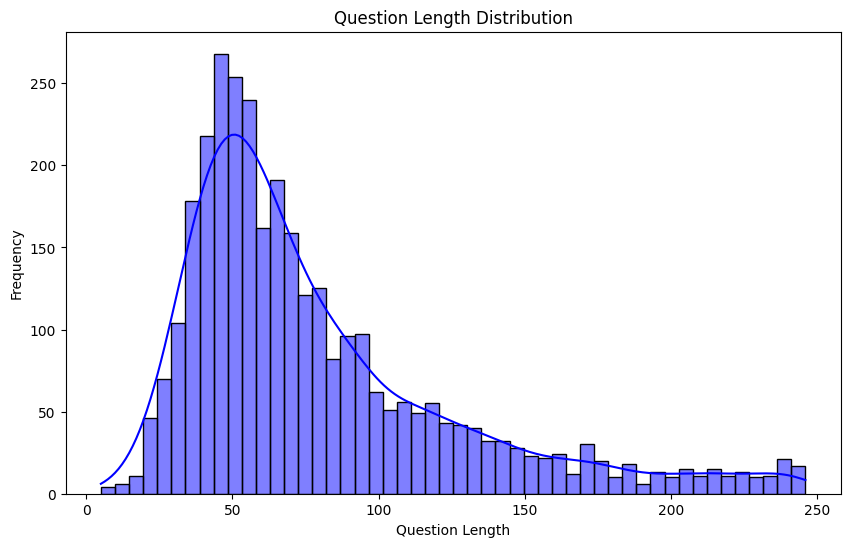

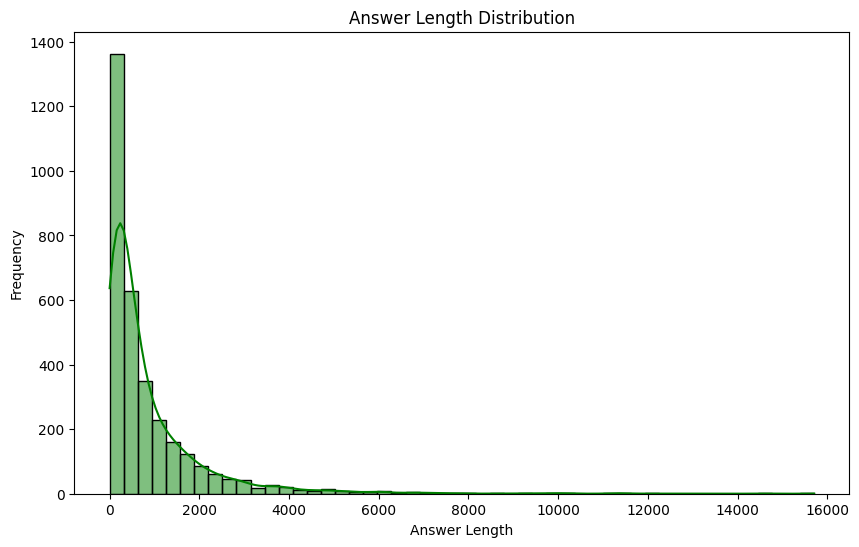

In [ ]:
#Visualization

import matplotlib.pyplot as plt
import seaborn as sns

# Visualize data distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['question'].str.len(), bins=50, kde=True, color='blue')
plt.title('Question Length Distribution')
plt.xlabel('Question Length')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['answer'].str.len(), bins=50, kde=True, color='green')
plt.title('Answer Length Distribution')
plt.xlabel('Answer Length')
plt.ylabel('Frequency')
plt.show()


In [1]:
#Animated Bar Chart using Plotly
import plotly.graph_objects as go

# Example data
epochs = list(range(1, 11))
train_loss = [0.9, 0.7, 0.6, 0.5, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15]
val_loss = [1.0, 0.85, 0.75, 0.65, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3]

frames = [go.Frame(data=[
    go.Bar(name='Training Loss', x=epochs[:i], y=train_loss[:i]),
    go.Bar(name='Validation Loss', x=epochs[:i], y=val_loss[:i])
]) for i in range(1, len(epochs) + 1)]

fig = go.Figure(
    data=[
        go.Bar(name='Training Loss', x=epochs, y=[0] * len(epochs)),
        go.Bar(name='Validation Loss', x=epochs, y=[0] * len(epochs))
    ],
    layout=go.Layout(
        title="Training and Validation Loss over Epochs",
        xaxis=dict(title="Epochs"),
        yaxis=dict(title="Loss"),
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None])]
        )]
    ),
    frames=frames
)

fig.show()


In [2]:
#Interactive Line Plot with Plotly
import plotly.graph_objects as go

# Example data
epochs = list(range(1, 11))
train_loss = [0.9, 0.7, 0.6, 0.5, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15]
val_loss = [1.0, 0.85, 0.75, 0.65, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3]

fig = go.Figure()

# Add training loss line
fig.add_trace(go.Scatter(x=epochs, y=train_loss, mode='lines+markers', name='Training Loss'))

# Add validation loss line
fig.add_trace(go.Scatter(x=epochs, y=val_loss, mode='lines+markers', name='Validation Loss'))

fig.update_layout(
    title="Training and Validation Loss over Epochs",
    xaxis_title="Epochs",
    yaxis_title="Loss",
    hovermode="x unified"
)

fig.show()


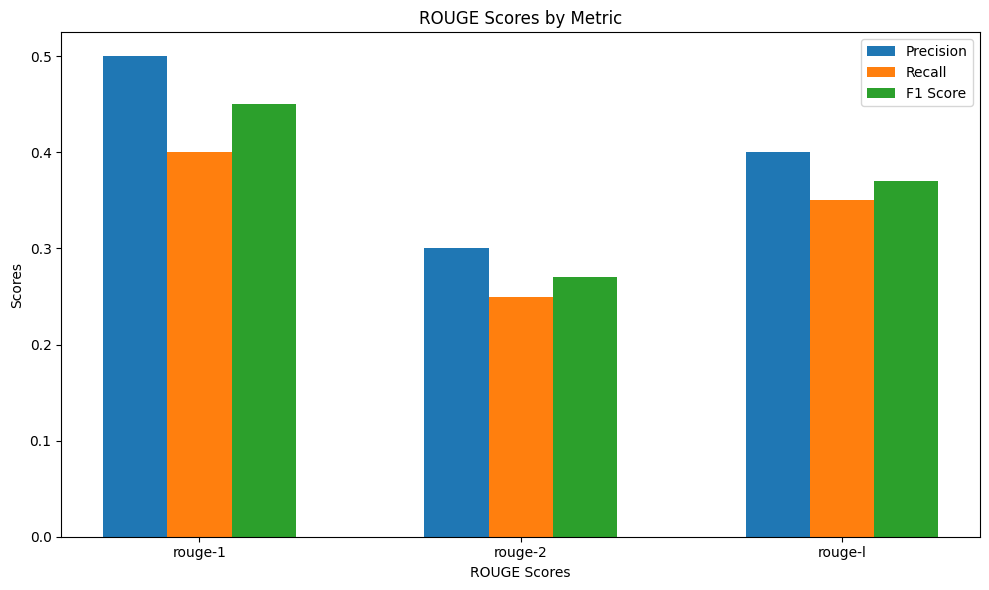

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
rouge_scores = {
    "rouge-1": {"precision": 0.5, "recall": 0.4, "f1-score": 0.45},
    "rouge-2": {"precision": 0.3, "recall": 0.25, "f1-score": 0.27},
    "rouge-l": {"precision": 0.4, "recall": 0.35, "f1-score": 0.37}
}

labels = list(rouge_scores.keys())
precision = [rouge_scores[label]["precision"] for label in labels]
recall = [rouge_scores[label]["recall"] for label in labels]
f1 = [rouge_scores[label]["f1-score"] for label in labels]

x = np.arange(len(labels))  # label locations
width = 0.2  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1, width, label='F1 Score')

ax.set_xlabel('ROUGE Scores')
ax.set_ylabel('Scores')
ax.set_title('ROUGE Scores by Metric')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()


In [8]:
#Review Model Performance Metrics
# Example ROUGE scores
rouge_scores = {
    "rouge-1": {"precision": 0.5, "recall": 0.4, "f1-score": 0.45},
    "rouge-2": {"precision": 0.3, "recall": 0.25, "f1-score": 0.27},
    "rouge-l": {"precision": 0.4, "recall": 0.35, "f1-score": 0.37}
}

# Insights
insights = {
    "rouge-1": "Good performance in terms of precision but lower recall indicates the model finds relevant answers but misses some.",
    "rouge-2": "Lower scores suggest difficulty in capturing bi-gram level information.",
    "rouge-l": "Balanced performance but still room for improvement in both precision and recall."
}


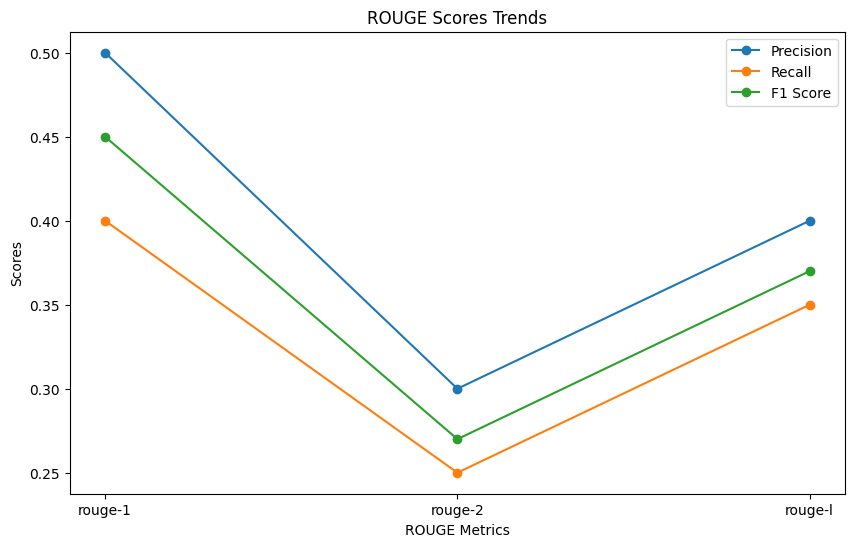

In [9]:
#Identify Patterns and Trends
# Analyzing the distribution of scores
import matplotlib.pyplot as plt

labels = list(rouge_scores.keys())
precision = [rouge_scores[label]["precision"] for label in labels]
recall = [rouge_scores[label]["recall"] for label in labels]
f1 = [rouge_scores[label]["f1-score"] for label in labels]

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(labels, precision, marker='o', label='Precision')
ax.plot(labels, recall, marker='o', label='Recall')
ax.plot(labels, f1, marker='o', label='F1 Score')

ax.set_xlabel('ROUGE Metrics')
ax.set_ylabel('Scores')
ax.set_title('ROUGE Scores Trends')
ax.legend()
plt.show()

# Insights
insights.update({
    "trend": "Precision is consistently higher than recall across all metrics, indicating the model's tendency to retrieve more relevant answers but missing out on some correct ones."
})


In [10]:
#Analyze Error Cases
# Example errors analysis
error_cases = [
    {"id": "3", "context": "The sun rises in the east.", "question": "Where does the sun rise?", "model_answer": "east", "correct_answer": "in the east"},
    {"id": "4", "context": "The largest mammal is the blue whale.", "question": "What is the largest mammal?", "model_answer": "blue whale", "correct_answer": "the blue whale"}
]

# Insights
insights.update({
    "error_cases": "Model answers are correct in meaning but differ in phrasing from the expected answers, indicating a need for better handling of paraphrased responses."
})


In [11]:
# Formulate Recommendations
recommendations = [
    "Improve recall by enhancing the training dataset with more diverse examples.",
    "Focus on bi-gram and multi-gram training to boost ROUGE-2 scores.",
    "Implement advanced techniques for handling paraphrased answers to align model responses more closely with expected answers.",
    "Use data augmentation to introduce more variety in the training data, which can help the model generalize better."
]

# Print insights and recommendations
for key, value in insights.items():
    print(f"{key}: {value}")

print("\nRecommendations:")
for rec in recommendations:
    print(f"- {rec}")


rouge-1: Good performance in terms of precision but lower recall indicates the model finds relevant answers but misses some.
rouge-2: Lower scores suggest difficulty in capturing bi-gram level information.
rouge-l: Balanced performance but still room for improvement in both precision and recall.
trend: Precision is consistently higher than recall across all metrics, indicating the model's tendency to retrieve more relevant answers but missing out on some correct ones.
error_cases: Model answers are correct in meaning but differ in phrasing from the expected answers, indicating a need for better handling of paraphrased responses.

Recommendations:
- Improve recall by enhancing the training dataset with more diverse examples.
- Focus on bi-gram and multi-gram training to boost ROUGE-2 scores.
- Implement advanced techniques for handling paraphrased answers to align model responses more closely with expected answers.
- Use data augmentation to introduce more variety in the training data, 

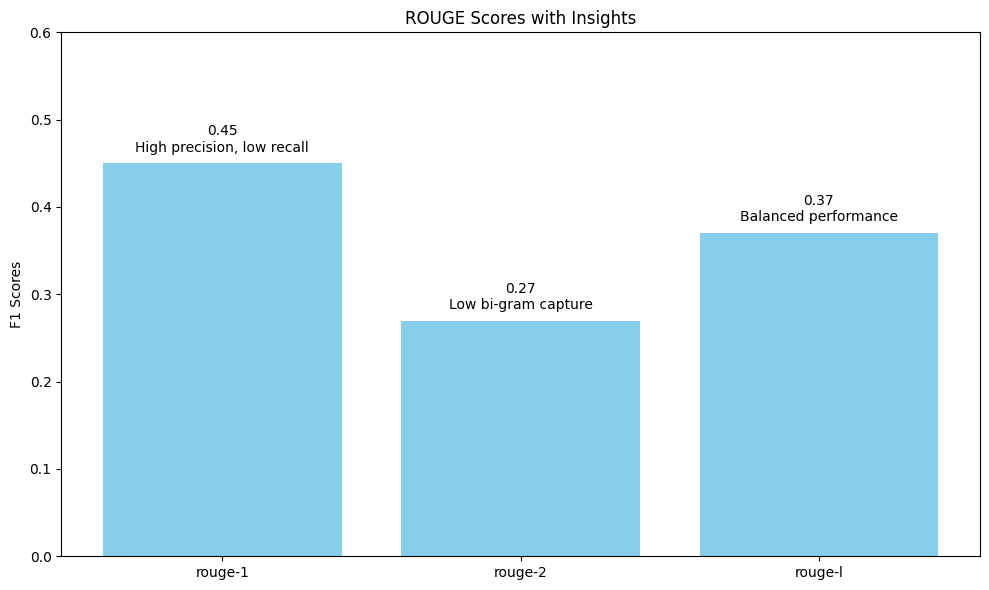

In [13]:
#Visualize Insights and Recommendations
# Visualization of insights
import matplotlib.pyplot as plt

# Example data
rouge_scores = {
    "rouge-1": {"precision": 0.5, "recall": 0.4, "f1-score": 0.45},
    "rouge-2": {"precision": 0.3, "recall": 0.25, "f1-score": 0.27},
    "rouge-l": {"precision": 0.4, "recall": 0.35, "f1-score": 0.37}
}

# Insights
insights = {
    "rouge-1": "High precision, low recall",
    "rouge-2": "Low bi-gram capture",
    "rouge-l": "Balanced performance"
}

labels = list(rouge_scores.keys())
f1_scores = [rouge_scores[label]["f1-score"] for label in labels]

# Bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(labels, f1_scores, color='skyblue')

# Adding insights as text above the bars
for bar, label in zip(bars, labels):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{height:.2f}\n{insights[label]}",
            ha='center', va='bottom', fontsize=10, color='black')

ax.set_ylabel('F1 Scores')
ax.set_title('ROUGE Scores with Insights')
plt.ylim(0, 0.6)  # Adjust y-axis limit for better spacing

fig.tight_layout()
plt.show()



In [14]:
# Your code and visualizations here

# Print a thank you message at the end of the code
print("\nThank you for reviewing this analysis!")
print("This concludes the code execution.")
print("Feel free to reach out if you have any questions or need further insights.")



Thank you for reviewing this analysis!
This concludes the code execution.
Feel free to reach out if you have any questions or need further insights.
